In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

from data_load import *
from model_fit_functions import *

from sklearn.utils import shuffle

import pandas as pd
import numpy as np

import pickle

import random
from sklearn.metrics.pairwise import euclidean_distances

import numpy as np
from sklearn.decomposition import PCA

import copy
import pickle

In [3]:
# Load data
data_dict =  load_split_pool(1346, 430, 10, scale = True)

# Pooled X data
train_df_pooled = data_dict["x_pooled"]["train"]
val_df_pooled = data_dict["x_pooled"]["val"]

Directory: Complete_Spectral_Data\Training_Data Physical properties shape: (1346, 5) Spectral prop shape: (1346, 110001)
Directory: Complete_Spectral_Data\Test_Data Physical properties shape: (810, 5) Spectral prop shape: (810, 110001)
Spectral data shape (2156, 110001)
Physical data shape (2156, 5)


In [ ]:
# train_df_pooled = train_df_pooled*data_dict["parameters"]["std"]
# val_df_pooled = val_df_pooled*data_dict["parameters"]["std"]

# PCA

In [4]:
def calculate_reconstr_loss_pca_2(pca, x_original, n_comp, trim = False, rescale = False, mean = None, std = None):
    '''
    Calulcate reconstruction loss for PCA with a given number of components.
    
    Inputs:
    - x_original: dataset on which to calculate the reconstruction loss (usually validation data)
    - n_comp: number of principal components to use
    - pca: estimated pca object (i.e. after calling the "fit" method)
    - trim: (True/False) should PCAreconstruction be trimmed at zero
    - rescale: Ture if loss should be calculated in the original scale
    - mean: supply if rescale = True
    - std: supply if rescale = True
    
    Returns:
    - loss
    - reconstructed dataset
    - transformed dataset'''
    
    x_projected = x_original @ pca.components_[:n_comp, :].T
    x_original_space = x_projected @ pca.components_[:n_comp, :]
    
    # Trimming done in the rescaled (original) scale, hence trim = True requires rescaled = True
#     if (trim == True) & (rescale == False):
#         rescale = True
#         print( "Warning! Trimmed set to true, hence setting rescale to True." )
#     else:
#         pass
    
    if rescale == True:
        x_original = rescale_back(x_original, mean, std)
        x_original_space = rescale_back( x_original_space, mean, std )
    else:
        pass
    
    if trim == True:
        x_original_space[x_original_space < 0] = 0
    else:
        pass
    
    loss = ((x_original - x_original_space) ** 2).sum().sum()/x_original.size
    
    return(x_projected, x_original_space, loss)

In [5]:
# Functio nto calculate distance ratios for pca

def compare_distances_pca(x, x_transformed, sample_size = 100):
    '''Calculate distance ratio between original and projected datapoints.
    
    Return projected_distances/original_distances, for the supplied original dataset (x) and transformed datase (x_transformed),
    based on a "sample_size" randomly drawn sample points.
    
    Input:
    - x: original dataset (numpy array or dataframe)
    - x_transformed : transformed/projected dataset (numpy array or dataframe)
    (the order in which they are supplied affects only their place in the final ratios).
    - sample_size: number of points to consider when calculating distance ratios (integer).
    
    Return:
    - mean and standard deviation of ratios between projected and original distances 
    (i.e. ratio = proejcted distance / original distance) 
    
    '''

    sample = random.sample(np.arange(0, x.shape[0], 1).tolist(), sample_size)
    
    # In case data were supplied as dataframes, convert them to numpy arrays
    try:
        x = x.to_numpy()
        x_transformed = x_transformed.to_numpy()
    except:
        pass
    
    x_to_compare = x_transformed[sample, :]

    # Calculate distances on the original data
    # Drop zero distances (i.e. those corresponding to distance between a point and itself)
    distances_original = euclidean_distances(x[sample, :], squared=True).ravel()
    nonzero_original = distances_original  != 0
    distances_original  = distances_original[nonzero_original]

    # Calculate distances on the projected data
    distances_projected = euclidean_distances(x_to_compare, squared=True ).ravel()
    nonzero_projected = distances_projected  != 0
    distances_projected  = distances_projected[nonzero_projected]
    
    # Scaling to account for different dimensionality
    distances_projected = np.sqrt( x.shape[1]/x.shape[0] )*distances_projected

    # calculate distance ratios
    ratios = distances_projected / distances_original
    
    return( ratios.mean(), ratios.std())

In [6]:
def rescale_back(observation, mean, std):
    '''
    Reverse standardisation using the given parameters
    '''
    return( observation*std + mean ) 
#     return( observation + mean ) 


In [7]:
# Initialsie dictionary for storing results
pca_results_dict = dict()

# Create a sub-dictionary to store results specific for a given choice of n_comp
pca_results_dict["restricted_spaces"] = dict()

# different number of components to consider
n_comp_list = list( np.arange(2, 100, 2) )

# Fit PCA

pca = PCA(n_components=250)
pca.fit(train_df_pooled)
# transform train set
x_train_pca = pca.transform(train_df_pooled)
# transform val set
x_val_pca = pca.transform(val_df_pooled)


# Store main results, common to all choices of n_comp
pca_results_dict["object"] = pca
pca_results_dict["x_train_input"] = train_df_pooled
pca_results_dict["x_val_input"] = val_df_pooled

# dict for trimmed pca:
pca_trim_results_dict = deepcopy(pca_results_dict) # use deep copy to copy sub-elements

In [8]:
# def pca_projections_and_lossses(x, pca, n_comp):
#     '''
#     For a given dataset and number of components, project the dataset and calculate reconstruction loss
#     using a supplied (fitted) PCA object
    
#     Inputs:
#     - x: dataset
#     - pca: pca object (after calling ."fit" method)
#     - n_comp: number of principal components to use (i.e. dimension to which the dataset will be reuced)
    
#     Outputs:
#     - projected data
#     - recovered data
#     - reocnstruction loss
#     '''
    
#     # Project to smallet subspace (reduce dimensionality)
#     x_pca = x @ pca.components_[:n_comp, :].T
#     # Inverse transform (recover the data)
#     x_original_space_pca = x_pca @ pca.components_[:n_comp, :]
#     # reconstruction loss
#     loss = ((x - x_original_space_pca) ** 2).sum().sum()/x.size
    
#     return(x_pca, x_original_space_pca, loss)

In [9]:
# Caluclate PCA reconstruction loss and distances
trim = False

# iterate over different choices of n_comp
for n_comp in n_comp_list:
    
    pca_results_dict["restricted_spaces"][n_comp] = dict()
    
#     x_val_pca, x_val_original_space_pca, loss = pca_projections_and_lossses( val_df_pooled, pca, n_comp)
    x_val_pca, x_val_original_space_pca, loss = calculate_reconstr_loss_pca_2(pca, val_df_pooled, n_comp, 
                                                                               trim = trim, rescale = True, 
                                                                               mean = data_dict["parameters"]["mean"], std =  data_dict["parameters"]["std"])


    dist_ratios_mean, dist_ratios_std = compare_distances_pca(val_df_pooled, x_val_pca)

        
    pca_results_dict["restricted_spaces"][n_comp]["distances_mean"] = dist_ratios_mean
    pca_results_dict["restricted_spaces"][n_comp]["distances_std"] = dist_ratios_std
    pca_results_dict["restricted_spaces"][n_comp]["x_val_transformed"] = x_val_pca
    pca_results_dict["restricted_spaces"][n_comp]["x_val_original_space_pca"] = x_val_original_space_pca
    pca_results_dict["restricted_spaces"][n_comp]["loss"] = loss
    


In [10]:
# Caluclate PCA (trimmed) reconstruction loss and distances
trim = True


# iterate over different choices of n_comp
for n_comp in n_comp_list:
    
    pca_trim_results_dict["restricted_spaces"][n_comp] = dict()
    
#     x_val_pca, x_val_original_space_pca, loss = pca_projections_and_lossses( val_df_pooled, pca, n_comp)
    x_val_pca, x_val_original_space_pca, loss = calculate_reconstr_loss_pca_2(pca, val_df_pooled, n_comp, 
                                                                               trim = trim, rescale = True, 
                                                                               mean = data_dict["parameters"]["mean"], std =  data_dict["parameters"]["std"])


    dist_ratios_mean, dist_ratios_std = compare_distances_pca(val_df_pooled, x_val_pca)

        
    pca_trim_results_dict["restricted_spaces"][n_comp]["distances_mean"] = dist_ratios_mean
    pca_trim_results_dict["restricted_spaces"][n_comp]["distances_std"] = dist_ratios_std
    pca_trim_results_dict["restricted_spaces"][n_comp]["x_val_transformed"] = x_val_pca
    pca_trim_results_dict["restricted_spaces"][n_comp]["x_val_original_space_pca"] = x_val_original_space_pca
    pca_trim_results_dict["restricted_spaces"][n_comp]["loss"] = loss
    

In [16]:
pca = pca_results_dict.copy()

((pca['restricted_spaces'][6]['x_val_transformed'] - pca['restricted_spaces'][6]['x_val_original_space_pca'])**2).sum().sum()/pca['restricted_spaces'][50]['x_val_transformed'].size

30.273856938217452

In [18]:
pca_results_dict.keys()

dict_keys(['restricted_spaces', 'object', 'x_train_input', 'x_val_input'])

In [11]:
dump_object("pca", pca_results_dict)
dump_object("pca_trim", pca_trim_results_dict)

()

# Reconstruction loss

In [12]:
pca_loss = [ pca_results_dict["restricted_spaces"][i]["loss"] for i in pca_results_dict["restricted_spaces"] ]
pca_trim_loss = [ pca_trim_results_dict["restricted_spaces"][i]["loss"] for i in pca_trim_results_dict["restricted_spaces"] ]

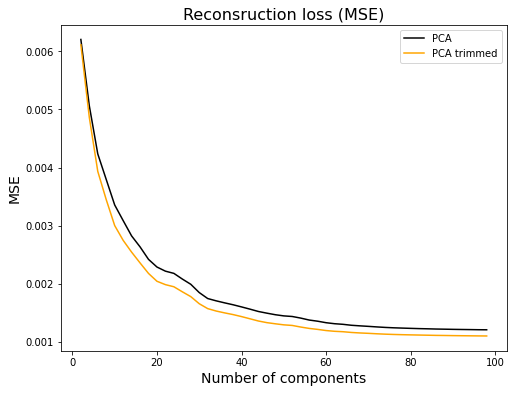

In [13]:
fig, ax = plt.subplots(figsize = (8,6))
ax.plot( np.array(n_comp_list), np.array(pca_loss) , label = "PCA", color = "black")
ax.plot( np.array(n_comp_list), np.array(pca_trim_loss) , label = "PCA trimmed", color = "orange")

ax.legend()
ax.set_title("Reconsruction loss (MSE)", fontsize = 16)
ax.set_ylabel("MSE", fontsize = 14)
ax.set_xlabel("Number of components", fontsize = 14);

# Appendix

The analysis below is included in "analysis" notebooks. I put it here just for an illustration, but it can be skipped or deleted 

## A1: Distance preservation

In [12]:
# Extract distances from the dictionary

dist_ratios_mean = [ pca_results_dict["restricted_spaces"][i]["distances_mean"] for i in pca_results_dict["restricted_spaces"] ]
dist_ratios_std = [ pca_results_dict["restricted_spaces"][i]["distances_std"] for i in pca_results_dict["restricted_spaces"] ]

dist_ratios_mean = np.array( dist_ratios_mean )
dist_ratios_std = np.array( dist_ratios_std )

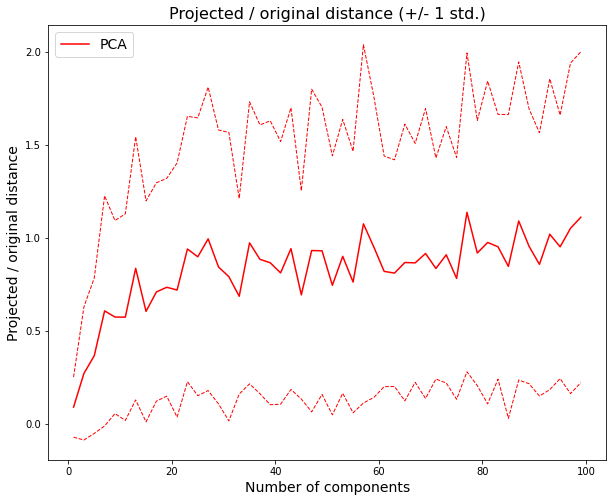

In [13]:
# Compare distance preservation between random projections and PCA 

fig, ax = plt.subplots(figsize = (10, 8))
ax.plot(np.array(n_comp_list), dist_ratios_mean,
        color = "red", label = "PCA" )
ax.plot(np.array(n_comp_list), dist_ratios_mean - dist_ratios_std,
        color = "red", linestyle = "--", linewidth = '1' )
ax.plot(np.array(n_comp_list), dist_ratios_mean + dist_ratios_std,
       color = "red", linestyle = "--", linewidth = '1' )
ax.set_title("Projected / original distance (+/- 1 std.)", fontsize = 16)
ax.set_ylabel("Projected / original distance", fontsize = 14)
ax.set_xlabel("Number of components", fontsize = 14);

ax.legend(fontsize = 14);

## A2: PCA Loadings

In [14]:
def calculate_std_abs_loadings(loadings, start_component, stop_component):
    '''
    Calulcate total absolute loadings of components starting with
    start_component and ending with stop_component -1. 
    This is as opposed to calculating loadings of components 1: (stop_component - 1).
    
    The loadings are standardise (divided by maximum value) to be below 1'''
    loadings_abs_pca_top = np.abs(loadings)[start_component:stop_component, :].T.sum(axis = 1)
    loadings_abs_pca_top = (loadings_abs_pca_top - loadings_abs_pca_top.min())/loadings_abs_pca_top.max()
    
    return(loadings_abs_pca_top)

In [15]:
# Calculate loadings of 1 st component, then of components 1 to 5, etc
comp_numbers_list = [0, 1, 5, 10, 50]
loadings_pca = [calculate_std_abs_loadings(pca.components_, comp_numbers_list[n], comp_numbers_list[n+1]
                                          ) for n in range(len(comp_numbers_list)-1)]

0
1
2
3


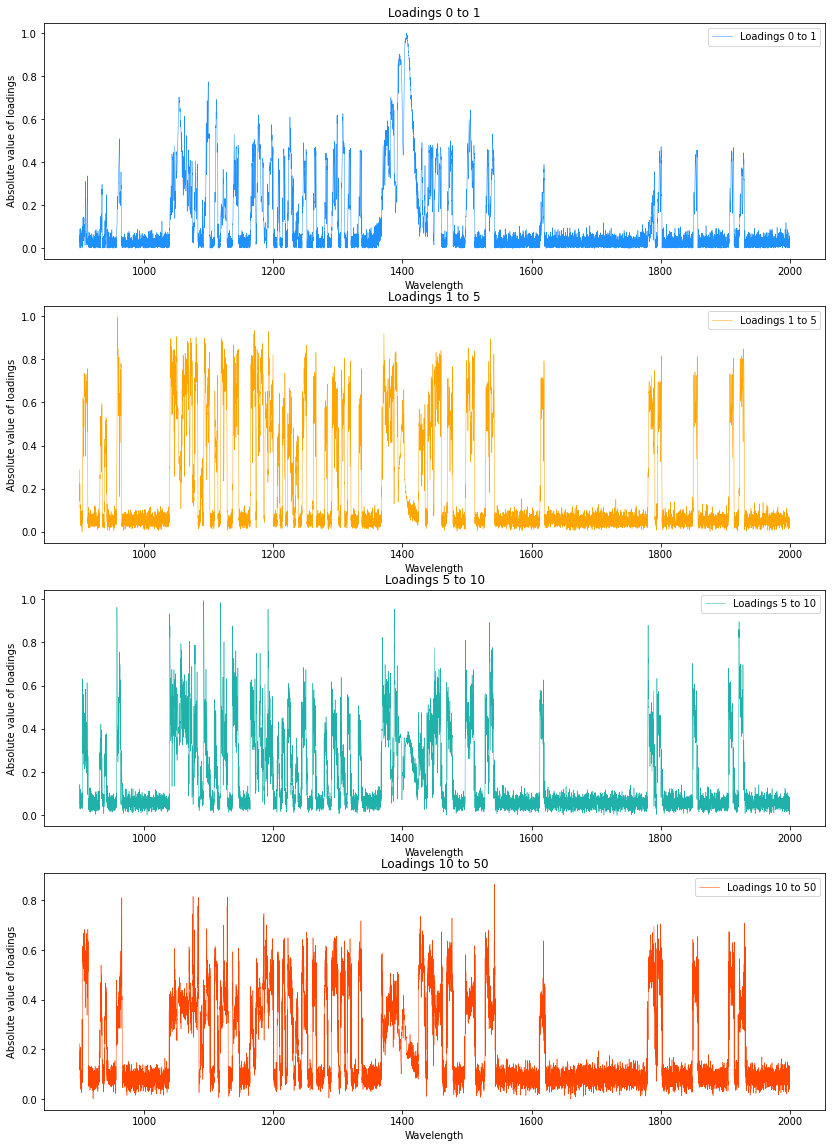

In [16]:
import matplotlib.pyplot as plt


plt, ax = plt.subplots(4, 1, figsize = (14, 20))

colors = ["dodgerblue", "orange", "lightseagreen", "orangered"]

i = 0
for loadings, loadings_num in zip(loadings_pca, comp_numbers_list[:-1]):
    plot_label = "Loadings " + str(comp_numbers_list[i]) + " to " + str(comp_numbers_list[i+1])
    print(i)
    ax[i].plot(data_dict["wavelengths"], loadings, label = plot_label, linewidth = 0.5, color = colors[i])
    ax[i].legend()
    ax[i].set_title(plot_label)
    ax[i].set_ylabel("Absolute value of loadings")
    ax[i].set_xlabel("Wavelength")
    
    i += 1



Text(0.5, 1.0, 'Absolute value of loadings (standardized) PCA')

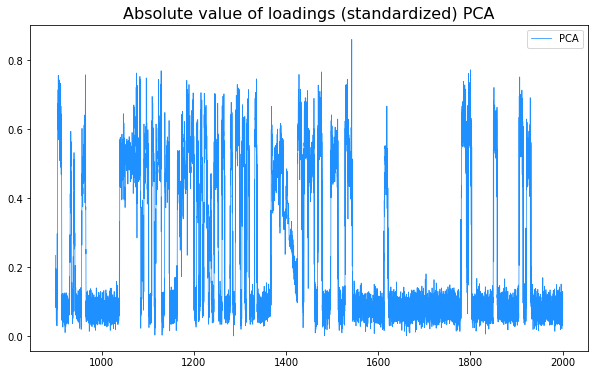

In [17]:

import matplotlib.pyplot as plt

pca_top50 = calculate_std_abs_loadings(pca.components_, 0, 50)

fig, ax = plt.subplots(figsize = (10, 6), sharex = True)

ax.plot( data_dict["wavelengths"], pca_top50, label = "PCA", linewidth = 0.75, color = "dodgerblue" )
ax.legend()
ax.set_title("Absolute value of loadings (standardized) PCA", fontsize = 16)

## A3: Signal reconstruction

In [55]:
# use treimmed PCA
trim = True

In [64]:
random.seed(6541)
number_of_elements = 50
random_number_list = random.sample(range(val_df_pooled.shape[0]), number_of_elements)
# number_of_elements = 50

print("Sample: ", np.array( random_number_list ) )

Sample:  [248 345 135  42 388 303 126  53 411 384 332  80 397 273 405 369 185 244
 288 189 309 416 216 197 287 247 315  49   5 125 227 228 155 235  67 222
  25 112 264 250 372 108 269  41  87 414  36 182 359 398]


In [71]:
_, obs_projected_pca_2, _ = calculate_reconstr_loss_pca_2(pca, val_df_pooled, n_comp, 
                                                                               trim = trim, rescale = True, 
                                                                               mean = data_dict["parameters"]["mean"], std =  data_dict["parameters"]["std"])
# obs_projected_pca_2 = obs_projected_pca_2.to_numpy()[random_number_list,:]

# Convert val set to the original scale
val_df_pooled_rescaled = rescale_back(val_df_pooled.to_numpy(), 
                             data_dict["parameters"]["mean"], 
                             data_dict["parameters"]["std"])


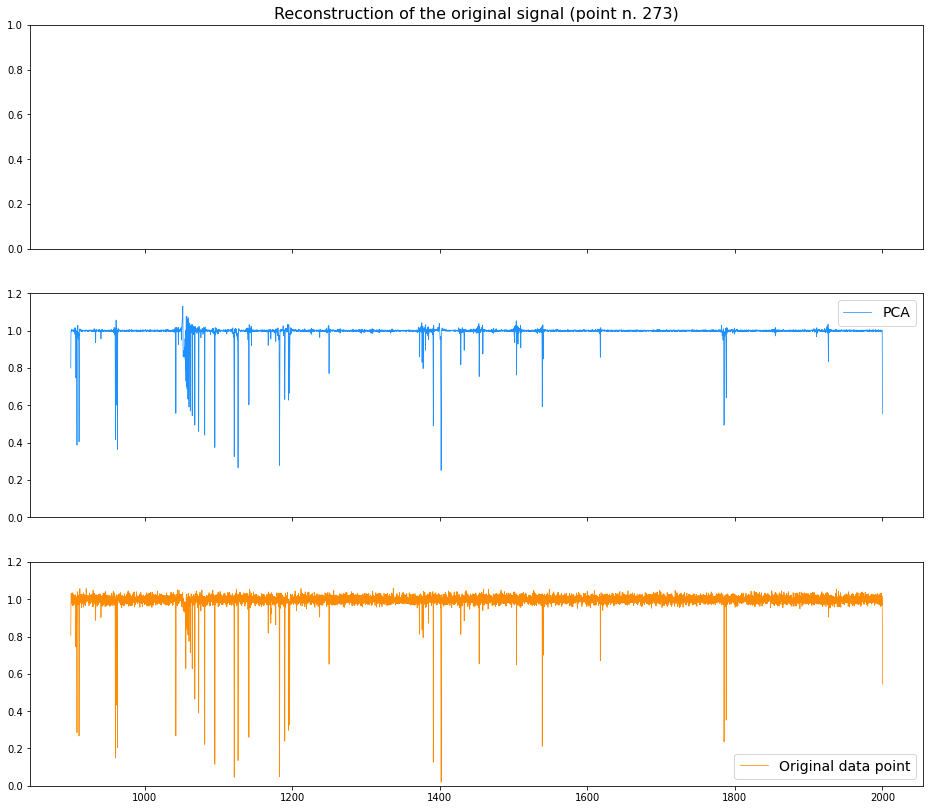

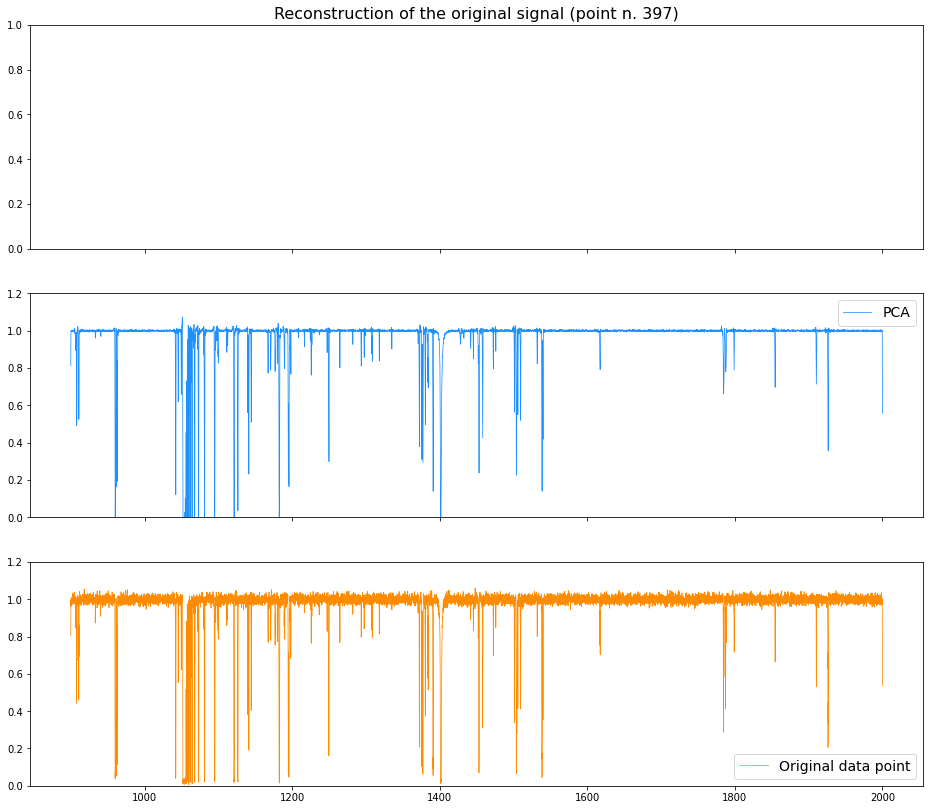

In [72]:
for random_number in random_number_list:

    # Recover PCA signal:
    recovered_signal = obs_projected_pca_2.to_numpy()[random_number,:]
    true_signal = val_df_pooled_rescaled[random_number,:]

    fig, ax = plt.subplots(3, 1, sharex = True, figsize = (16, 14))
    
    ax[1].plot(data_dict["wavelengths"], recovered_signal, label = "PCA", linewidth = 0.75, color = "dodgerblue")
    ax[1].legend(fontsize = 14)
    ax[1].set_ylim([0, 1.2])
    ax[2].plot(data_dict["wavelengths"], true_signal, label = "Original data point", linewidth = 0.75, color = "darkorange")
    ax[2].legend(fontsize = 14)
    ax[2].set_ylim([0, 1.2])
    ax[0].set_title("Reconstruction of the original signal (point n. " + str(random_number) + ")",
                   fontsize = (16));

##  A4: Error analysis

In [73]:
trim = True

val_projected_pca, val_original_space_proj_pca, loss_pca = calculate_reconstr_loss_pca_2(pca, val_df_pooled, n_comp,
                             rescale = True, trim = trim,
                             mean = data_dict["parameters"]["mean"],
                             std = data_dict["parameters"]["std"])


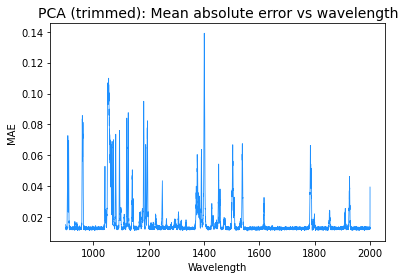

In [74]:
mean_abserror = np.abs(val_df_pooled_rescaled - val_original_space_proj_pca).mean(axis = 0)
std_abserror = np.abs(val_df_pooled_rescaled - val_original_space_proj_pca).std(axis = 0)

fig, ax = plt.subplots()
ax.plot(data_dict["wavelengths"], mean_abserror, color = "dodgerblue", linewidth = 0.8)
ax.set_xlabel("Wavelength")
ax.set_ylabel("MAE")
ax.set_title("PCA (trimmed): Mean absolute error vs wavelength", fontsize = 14);

Text(0.5, 0, 'Wavelength')

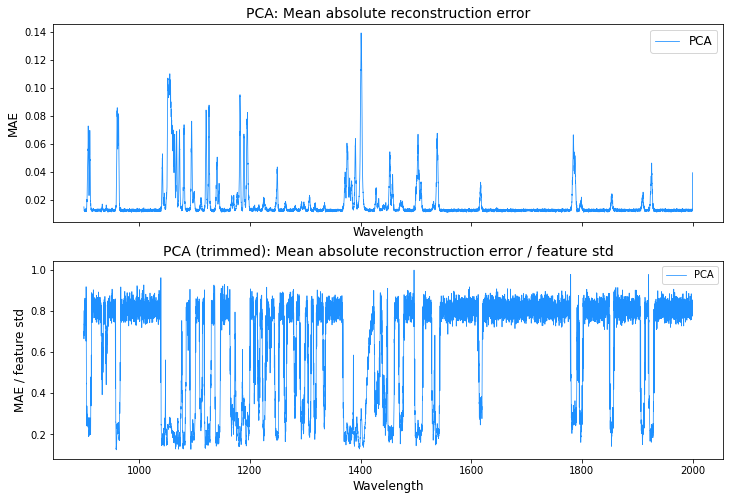

In [75]:
# fig, ax = plt.subplots(figsize = (10, 6))

fig, ax = plt.subplots( 2, 1, sharex = True, figsize = (12, 8) )
ax[0].plot(data_dict["wavelengths"], mean_abserror, color = "dodgerblue", linewidth = 0.8, label = "PCA")
ax[0].legend(fontsize = 12)
ax[0].set_xlabel("Wavelength", fontsize = 12)
ax[0].set_ylabel("MAE", fontsize = 12)
# ax[0].set_ylim([0, 0.2])
ax[0].set_title("PCA: Mean absolute reconstruction error", fontsize = 14)
# ax.plot(mean_abserror/mean_abserror.max())
ax[1].plot(data_dict["wavelengths"], mean_abserror/data_dict["parameters"]["std"], linewidth=0.75, color = "dodgerblue", label = "PCA" )
ax[1].legend()
ax[1].set_title("PCA (trimmed): Mean absolute reconstruction error / feature std", fontsize = 14)
ax[1].set_ylabel("MAE / feature std", fontsize = 12)
ax[1].set_xlabel("Wavelength", fontsize = 12)

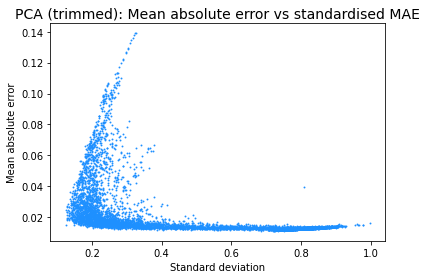

In [76]:
fig, ax = plt.subplots()
ax.scatter( mean_abserror/data_dict["parameters"]["std"], mean_abserror, s = 0.8, c = "dodgerblue" )
ax.set_xlabel("Standard deviation")
ax.set_ylabel("Mean absolute error")
ax.set_title("PCA (trimmed): Mean absolute error vs standardised MAE", fontsize = 14);

## A5: Errors and physical data

In [77]:
# load physical data

phys_var_cols = ['virial_rad', 'stellar_rad', 'impact', 'mass', 'disc']
phys_val = pd.DataFrame(data_dict["y"]["val"])
phys_val.columns = phys_var_cols 
phys_val.drop("mass", axis = 1, inplace = True)

# phys_val[["virial_rad", "stellar_rad"]] = np.log10(phys_val[["virial_rad", "stellar_rad"]])
phys_val.head()

scaler_y = StandardScaler()
phys_val_std = scaler_y.fit_transform(phys_val)

In [78]:
pca_errors = val_df_pooled_rescaled - val_original_space_proj_pca

In [79]:
pca_errors_means = pca_errors.mean(axis = 1)
pca_errors_means_std = (pca_errors_means - pca_errors_means.mean())/pca_errors_means.std() 

In [80]:
import statsmodels.api as sm
import numpy as np
duncan_prestige = sm.datasets.get_rdataset("Duncan", "carData")
Y = pca_errors_means_std
X = phys_val_std
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     25.67
Date:                Mon, 05 Jul 2021   Prob (F-statistic):           4.56e-19
Time:                        11:03:07   Log-Likelihood:                -563.12
No. Observations:                 430   AIC:                             1136.
Df Residuals:                     425   BIC:                             1157.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.975e-18      0.043   2.29e-16      1.0

In [90]:
coefs_array = np.empty(shape = (phys_val_std.shape[1] + 1, val_df_pooled_rescaled.shape[1]))
pvals_array = np.empty(shape = (phys_val_std.shape[1] + 1, val_df_pooled_rescaled.shape[1]))
rsquared_array = np.empty(shape = val_df_pooled_rescaled.shape[1])
std_array = np.empty(shape = (phys_val_std.shape[1] + 1, val_df_pooled_rescaled.shape[1]))

for feature_num in np.arange(0, val_df_pooled_rescaled.shape[1]):
    
    feature = pca_errors.iloc[:, feature_num]
    
    feature_std = ( feature - feature.mean() )/ feature.std()
    X = phys_val_std
    X = sm.add_constant(X)
    
    Y = feature_std
    model = sm.OLS(Y,X)
    results = model.fit()
    
    coefs_array[:, feature_num] = results.params
    pvals_array[:, feature_num] = results.pvalues
    std_array[:, feature_num] = results.bse
    rsquared_array[feature_num] = results.rsquared

In [94]:
def numpy_rolling_mean(np_array, window, min_periods = None, index = None):
    '''
    Return a rolling average of a given numpy array. The arguments window and min_periods specify how 
    to construct the rolling windows.
    '''
    df_series = pd.DataFrame(np_array)
    df_series.set_index(index, inplace = True)
    return( df_series.rolling(window, min_periods, center = True).mean() )

In [95]:
def plot_coefs_vs_wavelength(coefs, window, min_periods = None, title = None, xticks = None,
                            color = None, color_ma = None, y_lim = [None, None]):
    
    fig, ax = plt.subplots(figsize = (18, 10))
    ax.plot(xticks, coefs, linewidth=0.1, color = color )
    ax.tick_params(labelsize = 18)
    ax.plot(numpy_rolling_mean(coefs, window, min_periods, xticks), 
            linewidth=0.8, 
            color = color_ma );
    ax.set_ylim(y_lim)
    
    if title: ax.set_title(title, fontsize = 20);
    return()

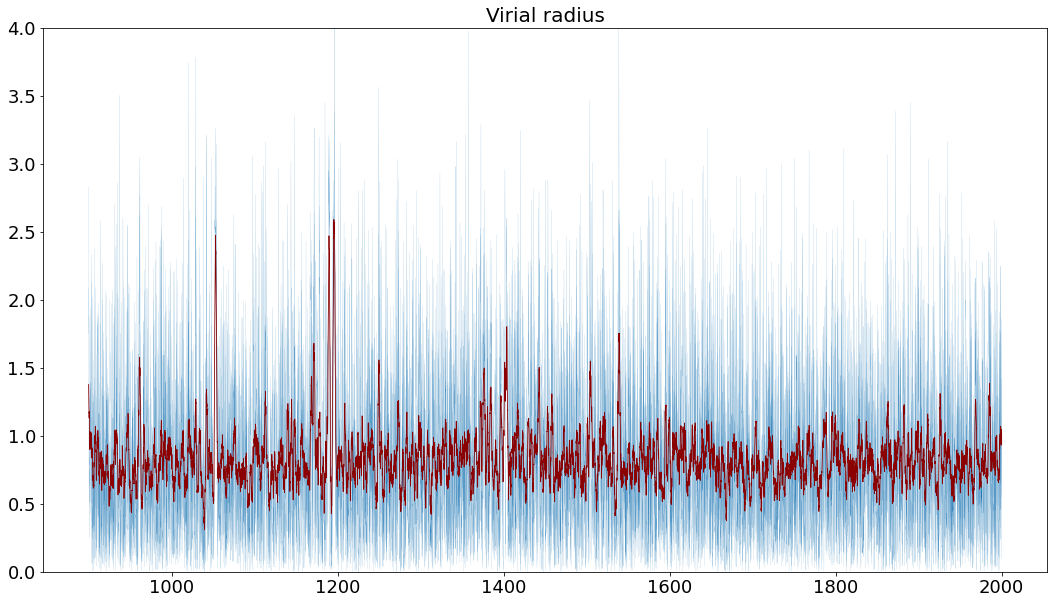

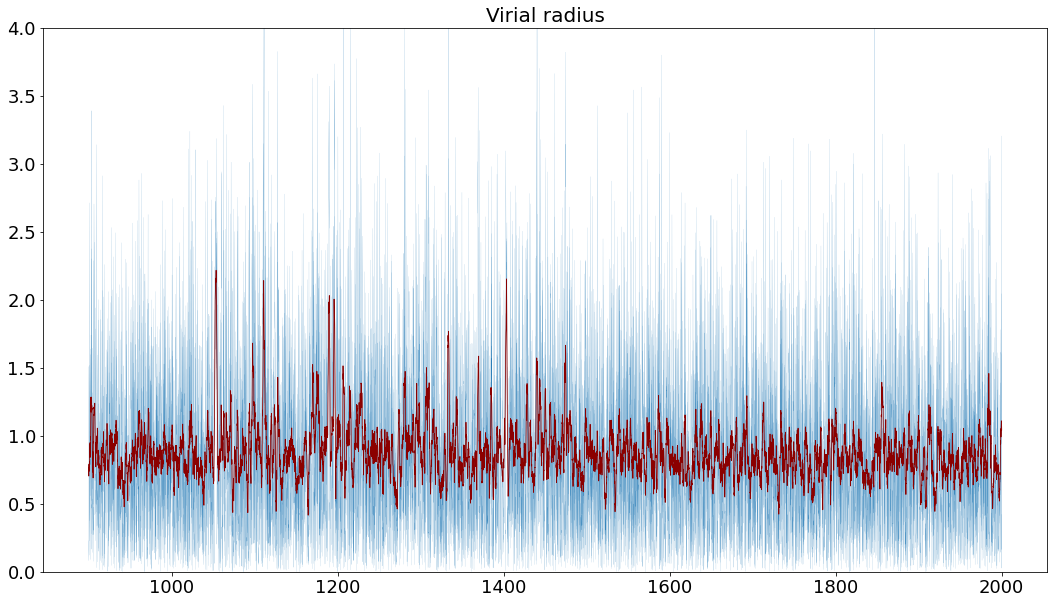

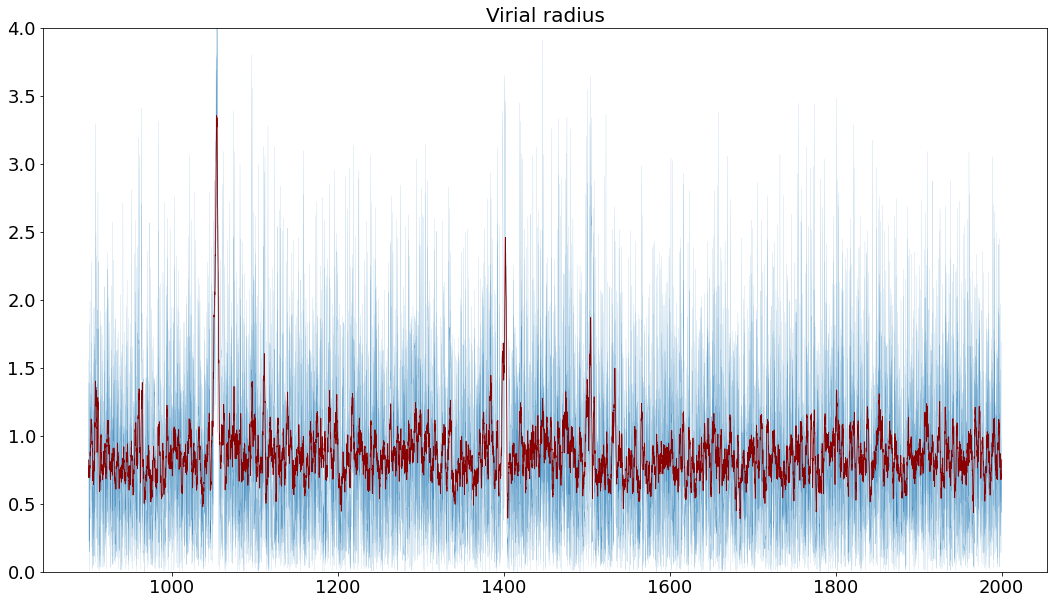

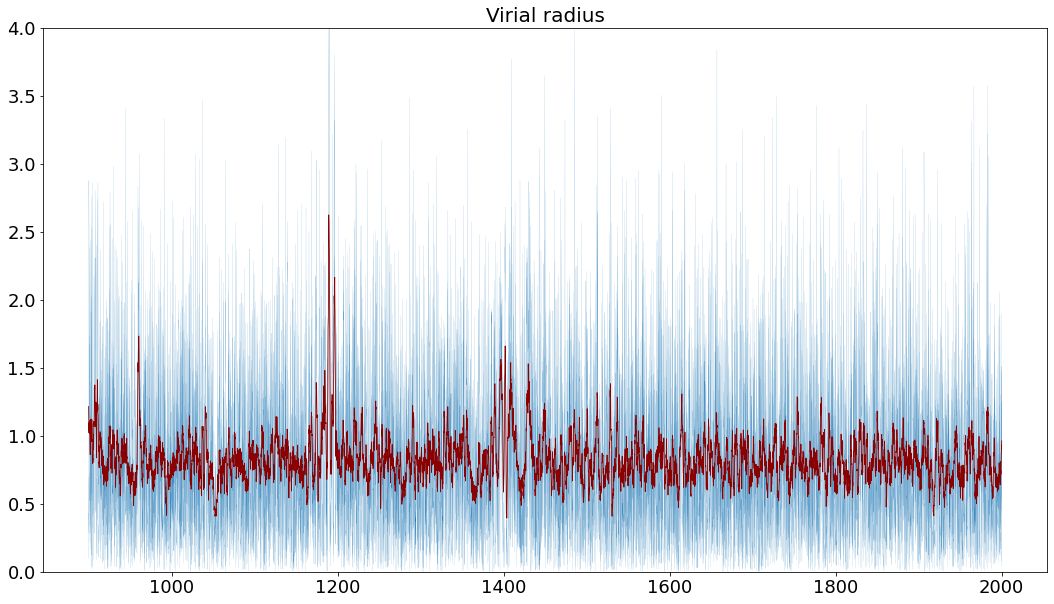

In [97]:
for i in np.arange(0, 4):

    plot_coefs_vs_wavelength( np.abs(coefs_array[i+1,:])/std_array[i+1,:], 20, 10, title = "Virial radius", 
                             xticks =data_dict["wavelengths"],
                        color_ma = "darkred", y_lim = [0, 4]) 